In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
import dask.dataframe as dd
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import train_test_split
import catboost

C:\Users\Yingting-PC\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
os.chdir('E:\personal project\Lending Club')

In [9]:
#dff = dd.read_csv('LoanStats_2015.csv',dtype='str')
#dff.loan_status.value_counts().compute()
#df=dff[dff.loan_status.isin(['Fully Paid','Charged Off','Late (31-120 days),','Default','In Grace Period','Late (16-30 days)'])].compute()
#df.reset_index(inplace=True,drop=True)
#df.to_csv('LoanStats_2015_nocurrent.csv',index=False)

In [10]:
df = pd.read_csv('LoanStats_2015_nocurrent.csv',dtype='str',encoding='latin-1')

In [11]:
df.shape

(249633, 145)

In [12]:
delete_col=df.isnull().sum()[df.isnull().sum()/len(df)>0.5].index.tolist()

In [13]:
df.drop(delete_col,inplace=True,axis=1)

In [14]:
# variables will not be used for applications model
not_used_cols=['funded_amnt','funded_amnt_inv','issue_d','pymnt_plan','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv',
'total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt',
'collections_12_mths_ex_med','policy_code','delinq_amnt','hardship_flag','debt_settlement_flag','last_credit_pull_d']

In [15]:
df.drop(not_used_cols,inplace=True,axis=1)

In [16]:
df.shape

(249633, 67)

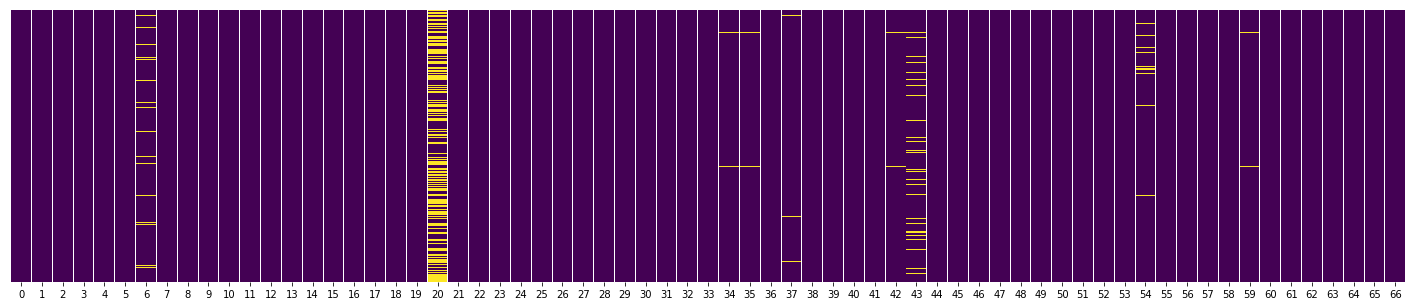

In [17]:
plt.figure(figsize=(25,5)) 
sns.set_context(font_scale=10)   
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis',xticklabels=list(range(len(df.columns))))

In [18]:
df.isnull().sum()[df.isnull().sum()>0]

emp_title                  13709
title                         65
dti                            2
mths_since_last_delinq    120457
revol_util                   110
bc_open_to_buy              2531
bc_util                     2707
mo_sin_old_il_acct          6782
mths_since_recent_bc        2422
mths_since_recent_inq      22490
num_rev_accts                  1
num_tl_120dpd_2m           11441
percent_bc_gt_75            2699
dtype: int64

In [19]:
# remove units
df.int_rate=df.int_rate.str[:-1]
df.revol_util=df.revol_util.str[:-1]
df.term=df.term.str[:3]

df.emp_length[(df.emp_length!='1 year')&(df.emp_length!='< 1 year')&(df.emp_length!='10+ years')]=df.emp_length[(df.emp_length!='1 year')&(df.emp_length!='< 1 year')&(df.emp_length!='10+ years')].str[:-6]
df.emp_length[df.emp_length=='< 1 year']=df.emp_length[df.emp_length=='< 1 year'].str[:-5]
df.emp_length[df.emp_length=='1 year']=df.emp_length[df.emp_length=='1 year'].str[:-5]
df.emp_length[df.emp_length=='10+ years']=df.emp_length[df.emp_length=='10+ years'].str[:-7]
# '<1 year'-->0, '10+ years'-->10
df.emp_length[df.emp_length=='< 1']=0
df.emp_length[df.emp_length=='']=np.nan

# keep first 3 digit of zipcode
df.zip_code=df.zip_code.str[:-2]

In [20]:
# good loans(0) and bad loan(1) 
df.loan_status.value_counts()

Fully Paid           183593
Charged Off           62042
In Grace Period        2943
Late (16-30 days)      1033
Default                  22
Name: loan_status, dtype: int64

In [21]:
# good loans(0) and bad loan(1) 
df['label']='0'
df.loc[df.loan_status.isin(['Charged Off','Late (16-30 days)','Default']),'label']='1'

In [22]:
df.label.value_counts()

0    186536
1     63097
Name: label, dtype: int64

In [23]:
# transform date into duration (in years)
earl_d=df.earliest_cr_line
earl_y=[datetime.strptime(x,'%m/%d/%Y').year for x in earl_d]
dur_y=np.repeat(2015,len(earl_y))-earl_y

In [24]:
df['dur_y']=dur_y

In [25]:
df.fillna(-999,inplace=True)

In [26]:
l_int=['loan_amnt','term','emp_length','zip_code','delinq_2yrs','inq_last_6mths',
      'mths_since_last_delinq','open_acc','pub_rec','revol_bal','total_acc','acc_now_delinq','tot_coll_amt',
      'tot_cur_bal','total_rev_hi_lim','acc_open_past_24mths','avg_cur_bal', 'bc_open_to_buy','chargeoff_within_12_mths', 
       'mo_sin_old_il_acct','mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl','mort_acc', 
       'mths_since_recent_bc', 'mths_since_recent_inq','num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl','num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 
       'num_tl_120dpd_2m','num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m','pub_rec_bankruptcies','tax_liens', 
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit','total_il_high_credit_limit','dur_y']
l_float=['int_rate','annual_inc','installment','dti','revol_util','bc_util','pct_tl_nvr_dlq', 'percent_bc_gt_75']
l_object=['grade', 'sub_grade', 'emp_title', 'home_ownership','verification_status', 'loan_status', 'purpose', 'title', 
          'addr_state','earliest_cr_line', 'initial_list_status', 'application_type','disbursement_method', 'label']

In [27]:
for i in l_int:
    df[i]=df[i].astype(int)
for i in l_float:
    df[i]=df[i].astype(float)
for i in l_object:
    df[i]=df[i].astype(object)

In [28]:
len(l_float)+len(l_int)+len(l_object)

69

In [29]:
dff=df.drop(['loan_status','earliest_cr_line'],axis=1)

In [30]:
#dff.to_csv('2015clean.csv',index=False)

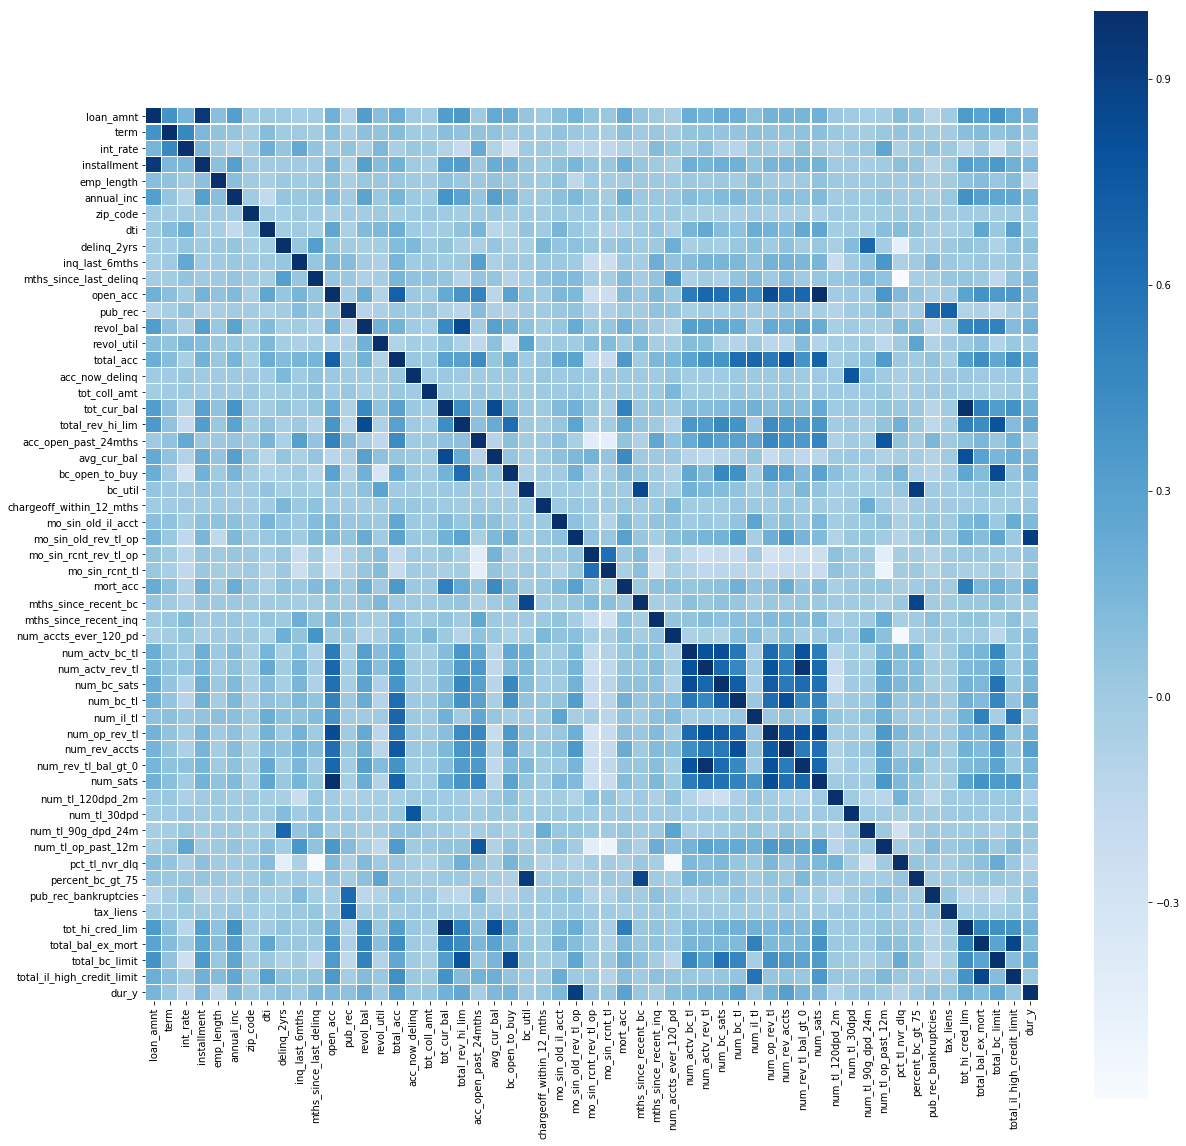

In [31]:
corr=dff.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr,cmap=plt.cm.Blues,square=True,annot_kws={'size':8},linewidths=0.1)

In [32]:
for i in corr.columns:
    high_cor=corr[i][1:][(corr[i].values[1:]>0.6)&(corr[i].values[1:]<1)]
    if high_cor.shape[0]>0:
        print(i)
        print(high_cor.sort_values(ascending=False))
        print('------------------')

loan_amnt
installment    0.949022
Name: loan_amnt, dtype: float64
------------------
delinq_2yrs
num_tl_90g_dpd_24m    0.663025
Name: delinq_2yrs, dtype: float64
------------------
open_acc
num_sats               0.998563
num_op_rev_tl          0.828745
total_acc              0.697116
num_rev_tl_bal_gt_0    0.664819
num_actv_rev_tl        0.660617
num_rev_accts          0.621972
num_bc_sats            0.607166
Name: open_acc, dtype: float64
------------------
pub_rec
tax_liens               0.699579
pub_rec_bankruptcies    0.639699
Name: pub_rec, dtype: float64
------------------
revol_bal
total_rev_hi_lim    0.838028
Name: revol_bal, dtype: float64
------------------
total_acc
num_rev_accts    0.740317
open_acc         0.697116
num_sats         0.692466
num_il_tl        0.670915
num_bc_tl        0.624423
Name: total_acc, dtype: float64
------------------
acc_now_delinq
num_tl_30dpd    0.76794
Name: acc_now_delinq, dtype: float64
------------------
tot_cur_bal
tot_hi_cred_lim    0.9859

In [33]:
#annual_inc--> log(annual_inc)
dff['log_inc']=np.log10(dff.annual_inc)
dff.loc[np.isinf(dff.log_inc)==True,'log_inc']=0.0

C:\Users\Yingting-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


In [34]:
ll_float=['int_rate','log_inc','installment','dti','revol_util','bc_util','pct_tl_nvr_dlq', 'percent_bc_gt_75']

C:\Users\Yingting-PC\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


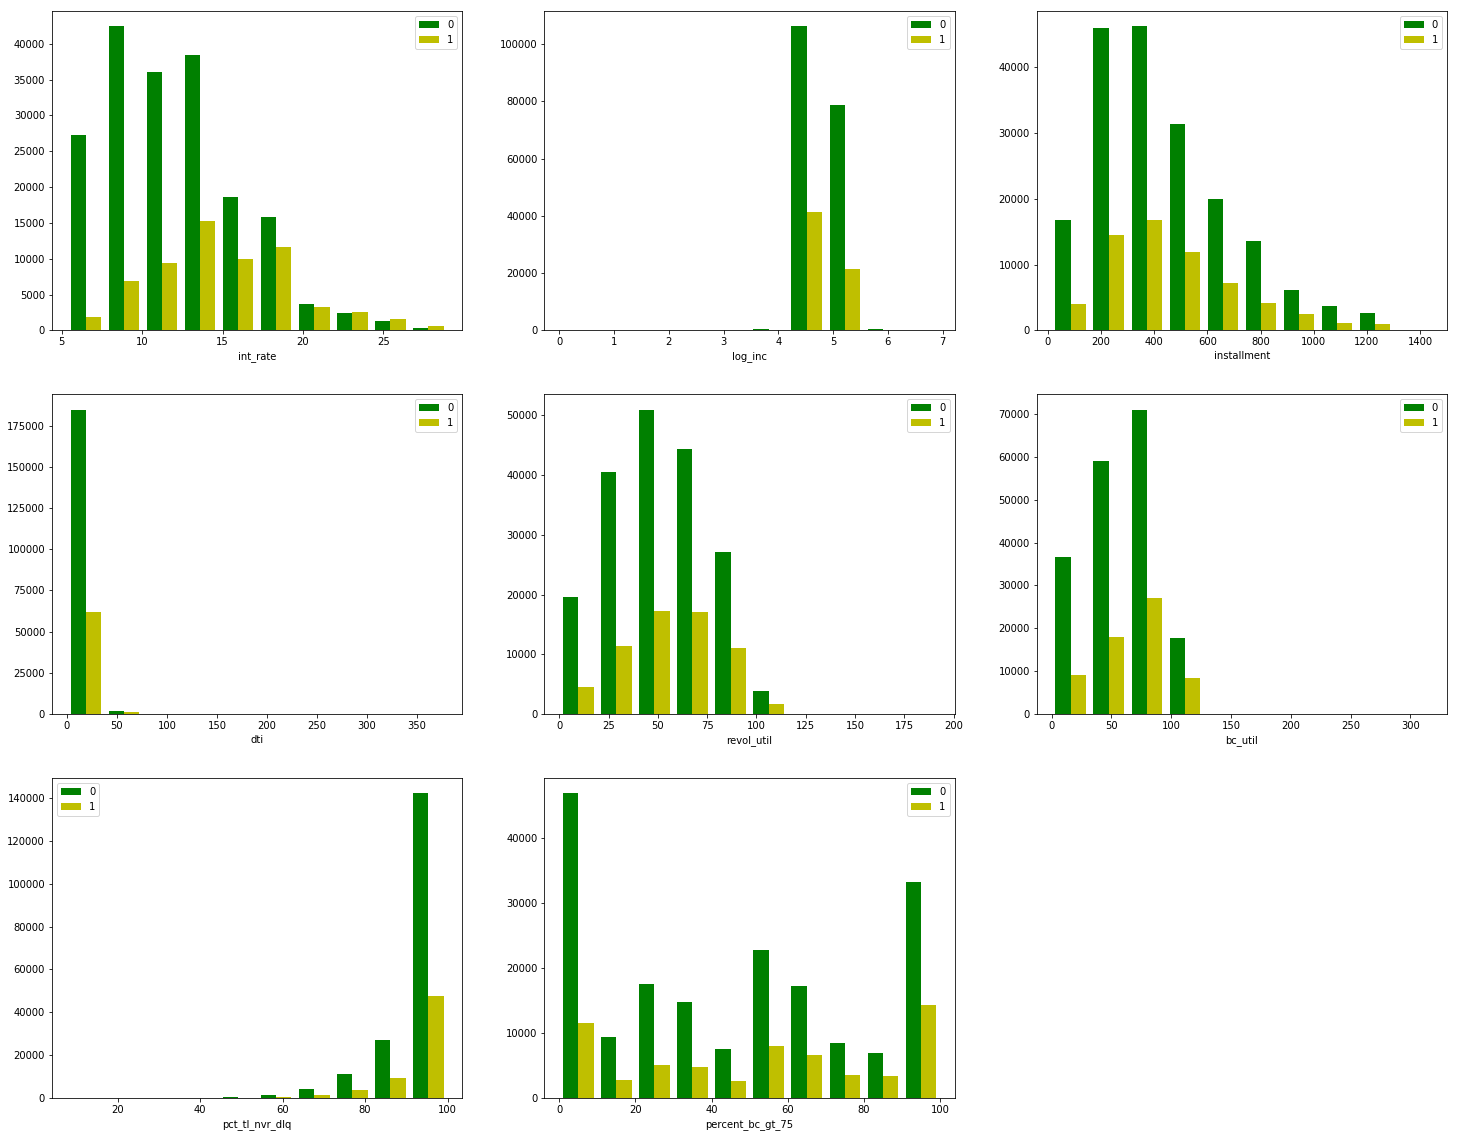

In [35]:
fig = plt.figure(figsize=(25,20))
for i in range(len(ll_float)):
    ax=fig.add_subplot(3, 3, i+1)
    x1=dff[dff['label']=='0'][ll_float[i]]
    x2=dff[dff['label']=='1'][ll_float[i]]
    x1=x1[x1!=-999]
    x2=x2[x2!=-999]
    ax.hist([x1, x2], color=['g','y'], label=['0','1'])
    ax.set_xlabel(ll_float[i])
    ax.legend()

In [36]:
# dti outlier
dff.dti.max()

380.53

In [37]:
# bc_util outlier
dff.bc_util.max()

318.2

In [38]:
# pct_tl_nvr_dlq outlier
dff.pct_tl_nvr_dlq.min()

7.7

In [88]:
len(ll_int)

46

In [87]:
# 'zip_code'
ll_int=['loan_amnt','term','emp_length','delinq_2yrs','inq_last_6mths',
      'mths_since_last_delinq','open_acc','pub_rec','revol_bal','total_acc','acc_now_delinq','tot_coll_amt',
      'tot_cur_bal','total_rev_hi_lim','acc_open_past_24mths','avg_cur_bal', 'bc_open_to_buy','chargeoff_within_12_mths', 
       'mo_sin_old_il_acct','mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl','mort_acc', 
       'mths_since_recent_bc', 'mths_since_recent_inq','num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl','num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 
       'num_tl_120dpd_2m','num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m','pub_rec_bankruptcies','tax_liens', 
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit','total_il_high_credit_limit','dur_y']

C:\Users\Yingting-PC\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


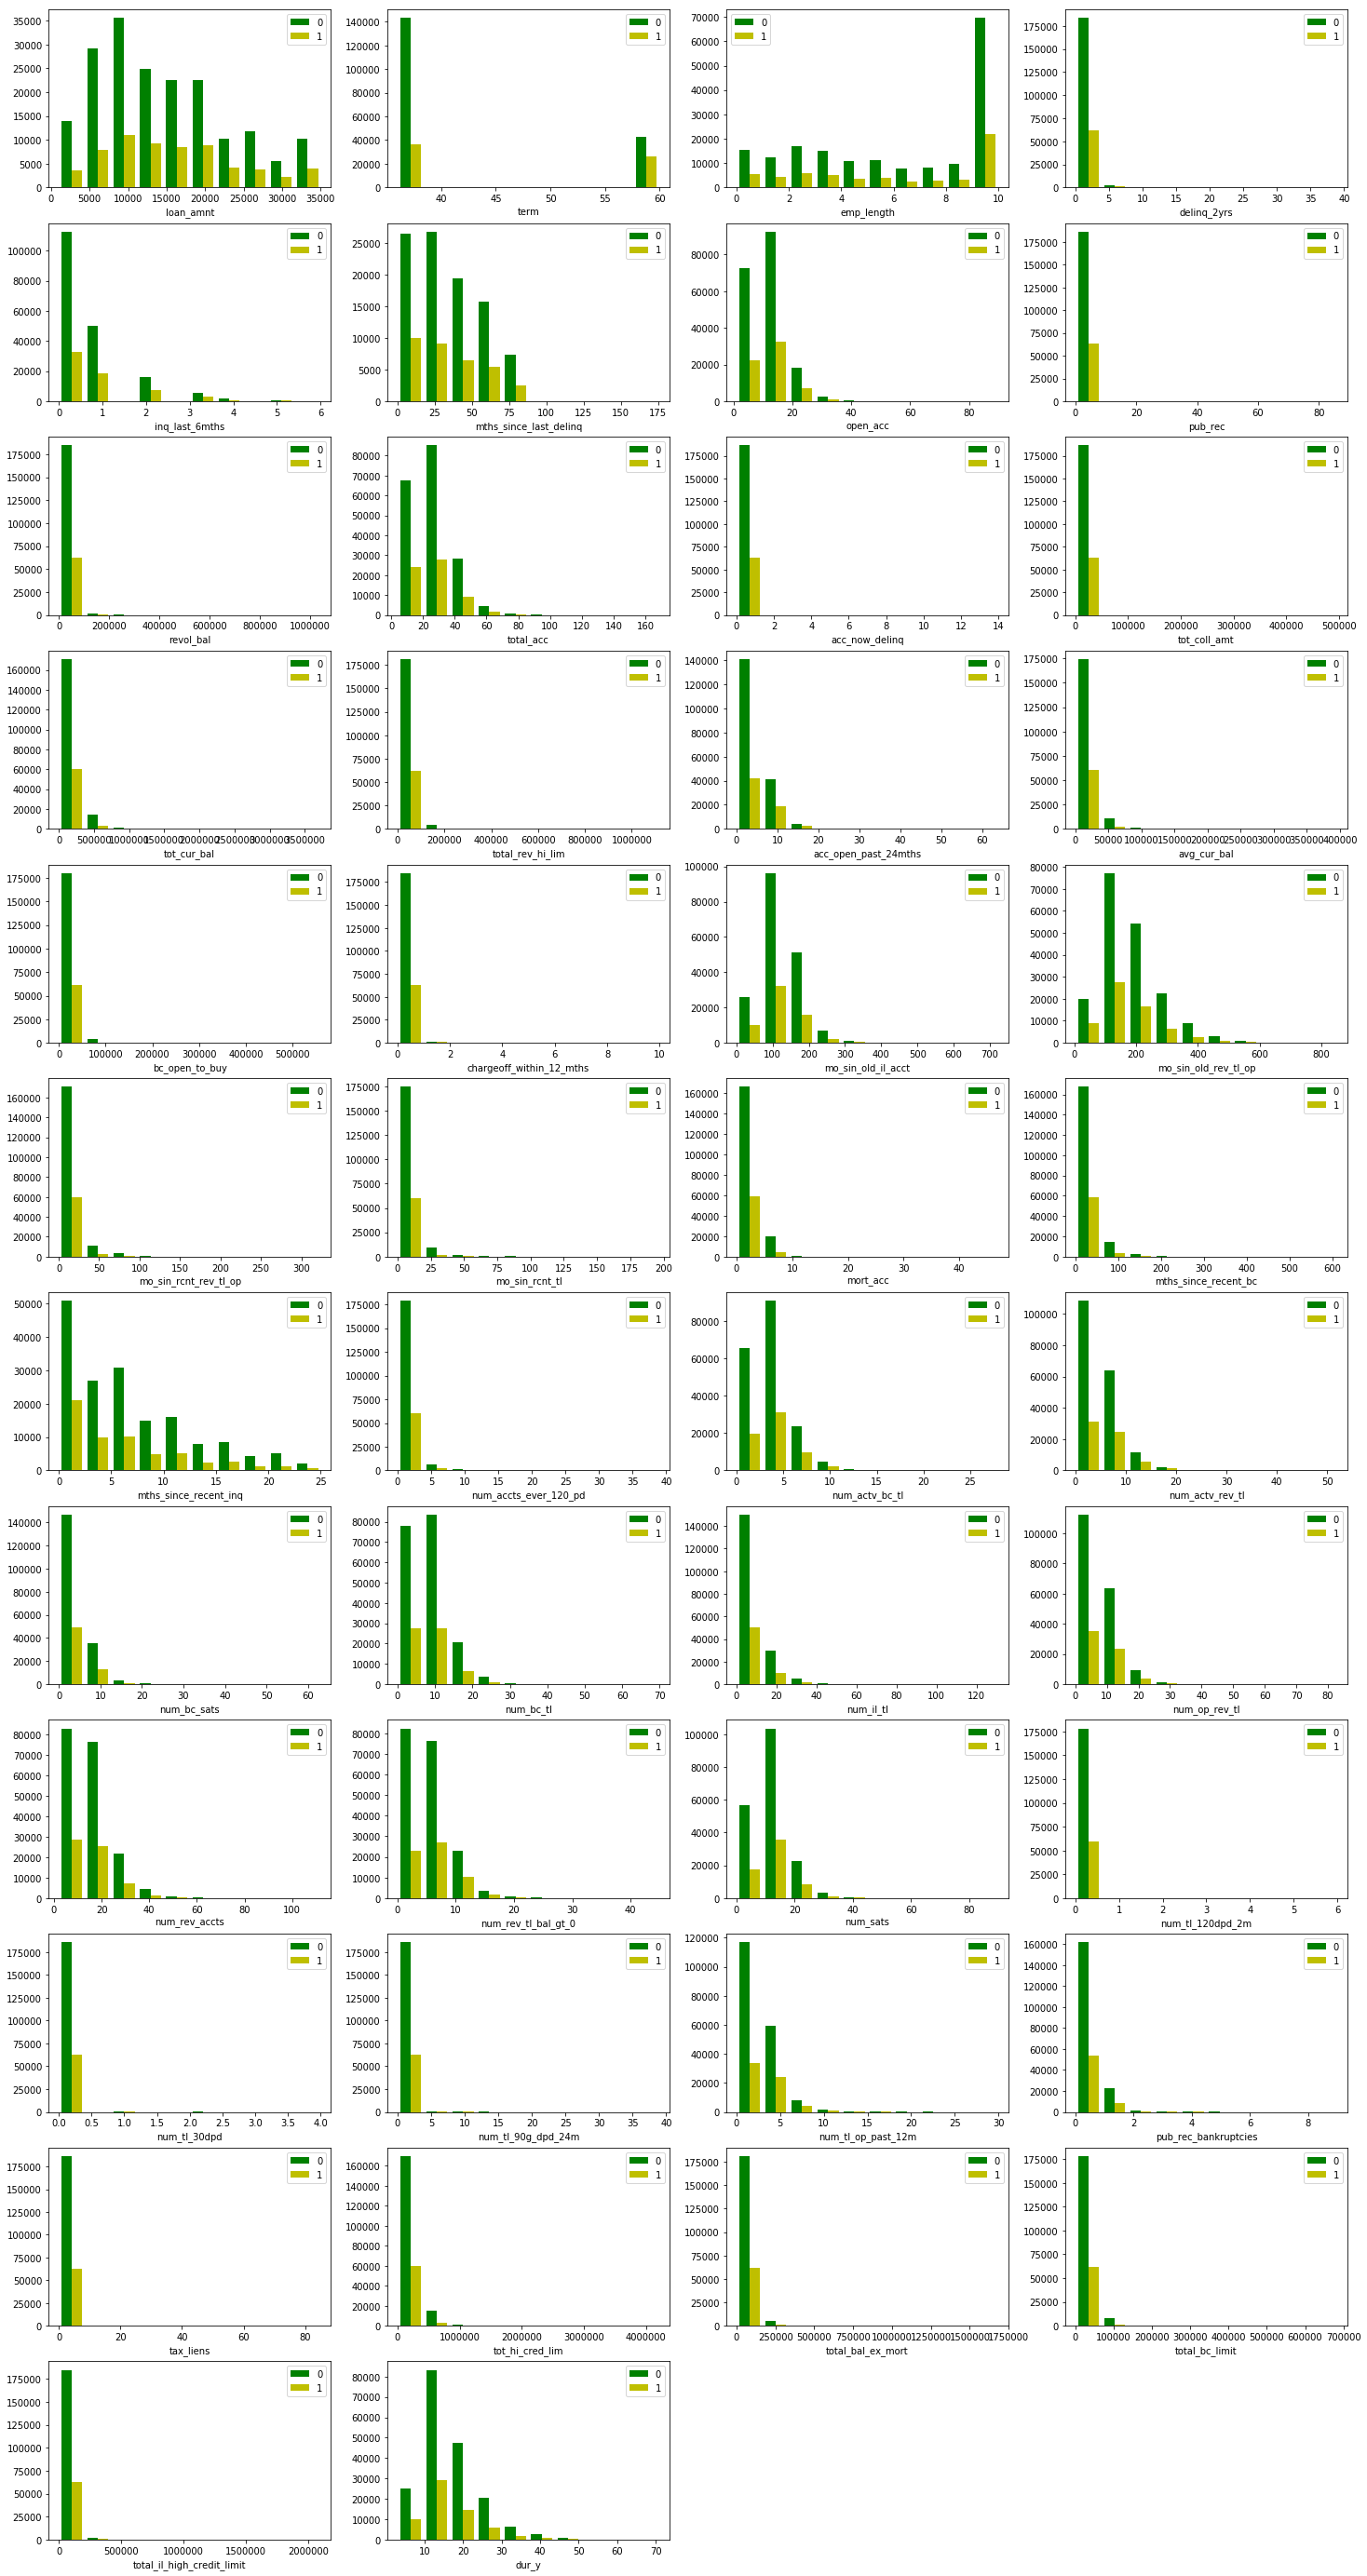

In [92]:
fig = plt.figure(figsize=(25,50))
for i in range(len(ll_int)):
    ax=fig.add_subplot(12, 4, i+1)
    x1=dff[dff['label']=='0'][ll_int[i]]
    x2=dff[dff['label']=='1'][ll_int[i]]
    x1=x1[x1!=-999]
    x2=x2[x2!=-999]
    ax.hist([x1, x2], color=['g','y'], label=['0','1'])
    ax.set_xlabel(ll_int[i])
    ax.legend()

In [39]:
#there is only one vaue "cash" for 'disbursement_method'
dff.drop('disbursement_method',axis=1,inplace=True)

In [40]:
ll_object=['grade', 'sub_grade', 'home_ownership', 'addr_state', 'initial_list_status', 'application_type',
           'verification_status', 'purpose', 'title']

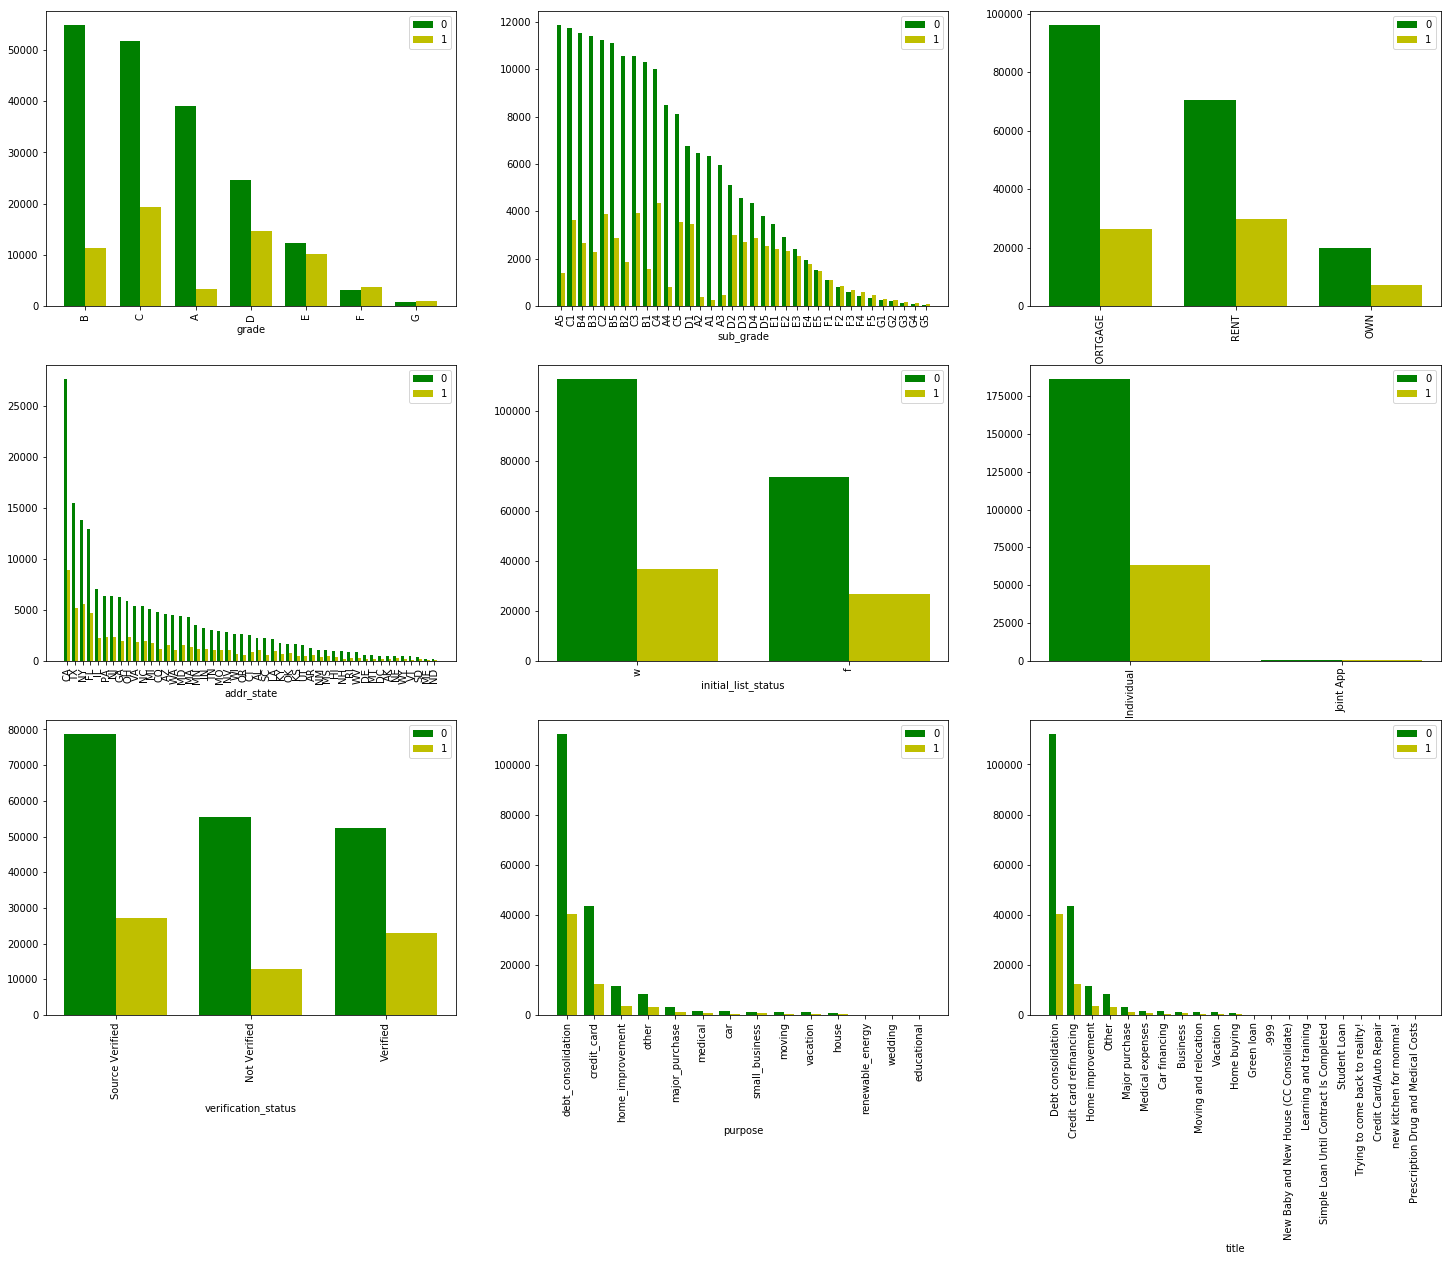

In [41]:
fig = plt.figure(figsize=(25,25))
for i in range(len(ll_object)):
    ax=fig.add_subplot(4, 3, i+1,)
    fea_df=dff[ll_object[i]]
    fea_ct=pd.crosstab(fea_df[fea_df!='-999'],dff.label).sort_values('0',ascending=False)
    width=0.38
    ind=np.arange(len(fea_ct.index))
    ax.bar(ind,fea_ct.iloc[:,0],width,color=['g'], label='0')
    ax.bar(ind+width,fea_ct.iloc[:,1],width,color=['y'], label='1')
    ax.set_xlabel(ll_object[i])
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(fea_ct.index.tolist())
    ax.legend()
    plt.setp(ax.get_xticklabels(), fontsize=10, rotation='vertical')

In [42]:
dff.emp_title.value_counts()
#'emp_title'

-999                                        13709
Teacher                                      4372
Manager                                      4091
Owner                                        1994
Supervisor                                   1834
Registered Nurse                             1800
RN                                           1761
Sales                                        1598
Project Manager                              1415
Driver                                       1396
Office Manager                               1161
Director                                     1138
General Manager                              1105
manager                                      1083
owner                                        1016
Engineer                                     1013
teacher                                       963
driver                                        929
President                                     855
Vice President                                790


In [43]:
lll_object=['grade', 'sub_grade', 'home_ownership', 'addr_state', 'initial_list_status', 'application_type',
           'verification_status', 'purpose', 'title','emp_title']

In [66]:
x_train, x_test, y_train, y_test = train_test_split(dff[ll_float+l_int+lll_object],dff['label'].astype(int),
                                                    test_size=0.2, random_state=33)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(199706, 65)
(49927, 65)
(199706,)
(49927,)


In [4]:
# https://tech.yandex.com/catboost/doc/dg/concepts/parameter-tuning-docpage/
cb=catboost.CatBoostClassifier(iterations=50,eval_metric='Accuracy',random_seed=33)

In [81]:
cb.fit(x_train[l_int+lll_object],y_train,list(range(47,57)))

0:	learn: 0.7535127	total: 3.79s	remaining: 3m 5s
1:	learn: 0.7538181	total: 6.36s	remaining: 2m 32s
2:	learn: 0.7542137	total: 9.1s	remaining: 2m 22s
3:	learn: 0.7540935	total: 12s	remaining: 2m 17s
4:	learn: 0.7539183	total: 15.8s	remaining: 2m 21s
5:	learn: 0.7539884	total: 19.7s	remaining: 2m 24s
6:	learn: 0.7538131	total: 22.9s	remaining: 2m 20s
7:	learn: 0.7540184	total: 26.9s	remaining: 2m 21s
8:	learn: 0.7540434	total: 29.5s	remaining: 2m 14s
9:	learn: 0.7539984	total: 31.7s	remaining: 2m 6s
10:	learn: 0.7542287	total: 34s	remaining: 2m
11:	learn: 0.7544140	total: 36s	remaining: 1m 54s
12:	learn: 0.7546343	total: 38.8s	remaining: 1m 50s
13:	learn: 0.7547244	total: 40.5s	remaining: 1m 44s
14:	learn: 0.7547395	total: 42.3s	remaining: 1m 38s
15:	learn: 0.7547645	total: 44.1s	remaining: 1m 33s
16:	learn: 0.7549648	total: 45.8s	remaining: 1m 28s
17:	learn: 0.7549898	total: 48s	remaining: 1m 25s
18:	learn: 0.7551300	total: 50.4s	remaining: 1m 22s
19:	learn: 0.7551350	total: 52.5s	rem

In [82]:
fea_imp=pd.DataFrame(cb.feature_importances_,index=l_int+lll_object,columns=['importance'])
fea_imp[fea_imp.importance>0].sort_values('importance',ascending=False)

,importance
sub_grade,40.047844
grade,12.459348
term,8.959810
home_ownership,6.580430
avg_cur_bal,5.150111
num_rev_tl_bal_gt_0,5.088205
mort_acc,4.269248
emp_length,2.929092
addr_state,2.836832
tot_hi_cred_lim,2.338083


In [84]:
lll_object

['grade',
 'sub_grade',
 'home_ownership',
 'addr_state',
 'initial_list_status',
 'application_type',
 'verification_status',
 'purpose',
 'title',
 'emp_title']